<a href="https://colab.research.google.com/github/Priyashree1312/Sriya.AI-/blob/main/paint_sales_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 1: Forecast monthly sales (Original Shipments in NOP) for LUXOL HI GLOSS SNOW-WHITE-.-1 L**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.1722 - val_loss: 0.1390
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1222 - val_loss: 0.1228
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0818 - val_loss: 0.1499
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0844 - val_loss: 0.1895
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0906 - val_loss: 0.1626
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0773 - val_loss: 0.1403
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0687 - val_loss: 0.1316
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0630 - val_loss: 0.1313
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0636 - val_loss: 0.1346
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0518 - val_loss: 0.1387
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0567 - val_loss: 0.1411
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0617 - val_l

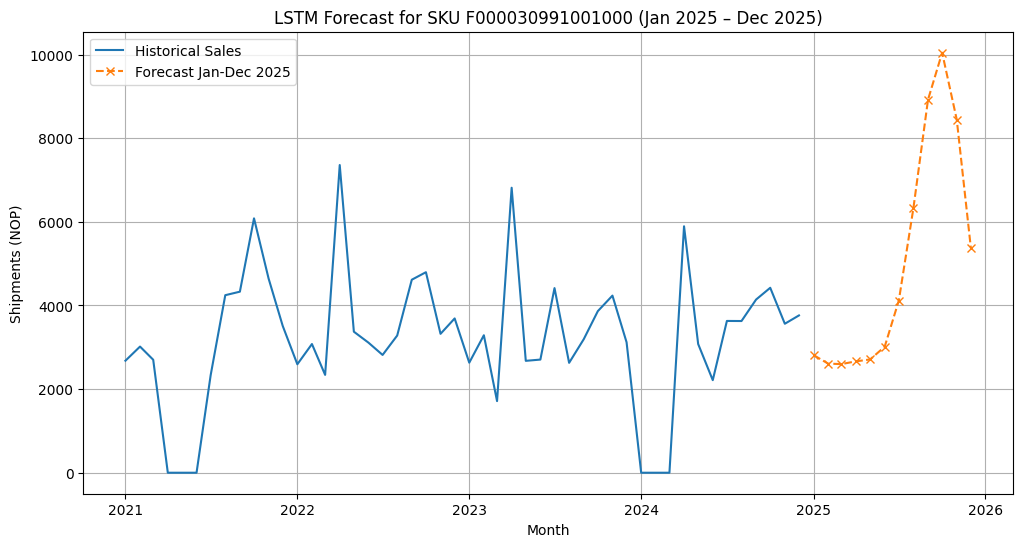

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pandas.tseries.offsets import MonthBegin
import matplotlib.pyplot as plt

# Load and filter sales data
df = pd.read_csv('Sales Data.csv')
sku = 'F000030991001000'
df_sku = df[df['Item.[SKU]'] == sku].copy()

# Parse year and month into datetime
df_sku['year'] = df_sku['Time.[Planning Year]'].str.extract(r'(\d{4})').astype(int)
df_sku['month_str'] = df_sku['Time.[Planning Month]'].str[:3]
df_sku['date'] = pd.to_datetime(df_sku['month_str'] + ' ' + df_sku['year'].astype(str), format='%b %Y')

# Monthly aggregation and missing month filling
monthly_sales = df_sku.groupby('date', as_index=False)['Original Shipments in NOP'].sum()
monthly_sales = monthly_sales.sort_values('date').set_index('date')
full_index = pd.date_range(start=monthly_sales.index.min(), end=monthly_sales.index.max(), freq='MS')
monthly_sales = monthly_sales.reindex(full_index)
monthly_sales['Original Shipments in NOP'] = monthly_sales['Original Shipments in NOP'].fillna(0)

# Add seasonality features
monthly_sales['month'] = monthly_sales.index.month
monthly_sales['month_sin'] = np.sin(2 * np.pi * monthly_sales['month'] / 12)
monthly_sales['month_cos'] = np.cos(2 * np.pi * monthly_sales['month'] / 12)

# Prepare feature matrix and scale
features = np.hstack([
    monthly_sales['Original Shipments in NOP'].values.reshape(-1, 1),
    monthly_sales['month_sin'].values.reshape(-1, 1),
    monthly_sales['month_cos'].values.reshape(-1, 1)
])
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Sequence builder
def create_sequences(data, look_back=3):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 3
X, y = create_sequences(features_scaled, look_back)
split_at = int(0.85 * len(X))
X_train, X_test = X[:split_at], X[split_at:]
y_train, y_test = y[:split_at], y[split_at:]

# LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=6, verbose=1, validation_split=0.1)

# Predict and inverse scaling on test set for evaluation
y_pred_scaled = model.predict(X_test)
last_features = X_test[:, -1, 1:]
y_pred_pad = np.hstack([y_pred_scaled, last_features])
y_test_pad = np.hstack([y_test.reshape(-1,1), last_features])
y_pred = scaler.inverse_transform(y_pred_pad)[:, 0]
y_true = scaler.inverse_transform(y_test_pad)[:, 0]

# Evaluation Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

print("Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAPE: {mape:.2f}%")

# Recursive forecast for Jan–Dec 2025
pred_months = 12
last_sequence = features_scaled[-look_back:]
future_preds_scaled = []

for i in range(pred_months):
    pred_input = last_sequence.reshape((1, look_back, features.shape[1]))
    pred_scaled = model.predict(pred_input, verbose=0)[0, 0]
    future_month_number = (monthly_sales.index[-1].month + i + 1 - 1) % 12 + 1
    month_sin = np.sin(2 * np.pi * future_month_number / 12)
    month_cos = np.cos(2 * np.pi * future_month_number / 12)
    new_features = np.array([[pred_scaled, month_sin, month_cos]])
    future_preds_scaled.append(pred_scaled)
    last_sequence = np.vstack([last_sequence[1:], new_features])

# Prepare for inverse scaling
future_feature_matrix = []
for i, pred_scaled in enumerate(future_preds_scaled):
    month_number = (monthly_sales.index[-1].month + i + 1 - 1) % 12 + 1
    month_sin = np.sin(2 * np.pi * month_number / 12)
    month_cos = np.cos(2 * np.pi * month_number / 12)
    future_feature_matrix.append([pred_scaled, month_sin, month_cos])
future_feature_matrix = np.array(future_feature_matrix)
future_preds = scaler.inverse_transform(future_feature_matrix)[:, 0]

# Month labels for forecast
start_pred_date = monthly_sales.index[-1] + MonthBegin(1)
pred_dates = pd.date_range(start=start_pred_date, periods=pred_months, freq='MS')
forecast_df = pd.DataFrame({'Month': pred_dates, 'Forecasted_Sales': future_preds})
forecast_df.set_index('Month', inplace=True)
print(forecast_df)

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['Original Shipments in NOP'], label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecasted_Sales'], marker='x', linestyle='--', label='Forecast Jan-Dec 2025')
plt.title('LSTM Forecast for SKU F000030991001000 (Jan 2025 – Dec 2025)')
plt.xlabel('Month')
plt.ylabel('Shipments (NOP)')
plt.legend()
plt.grid(True)
plt.show()


# **Experiment 2: Forecast monthly sales (Original Shipments in NOP) for Berger GP Thinner PET- THINNER-1 L (SKU: F0003E0900001000)**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX

# --- 1. Load & Filter Data ---
df = pd.read_csv('Sales Data.csv')  # Update with correct path
sku = 'F0003E0900001000'
product = 'BERGER GP THINNER-* THINNER-1 L'

df_sku = df[(df['Item.[SKU]'] == sku) & (df['SKU Description'] == product)].copy()
df_sku['year'] = df_sku['Time.[Planning Year]'].str.extract(r'(\d{4})').astype(int)
df_sku['month_str'] = df_sku['Time.[Planning Month]'].str[:3]
df_sku['date'] = pd.to_datetime(df_sku['month_str'] + ' ' + df_sku['year'].astype(str), format='%b %Y')

monthly_sales = df_sku.groupby('date')['Original Shipments in NOP'].sum().asfreq('MS').fillna(0)
df_feat = pd.DataFrame(monthly_sales)
df_feat.columns = ['sales']

# --- 2. Feature Engineering ---
df_feat['month'] = df_feat.index.month
df_feat['year'] = df_feat.index.year
df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)
for l in [1, 3, 6, 12]:
    df_feat[f'lag_{l}'] = df_feat['sales'].shift(l).fillna(0)
    df_feat[f'roll_{l}'] = df_feat['sales'].rolling(l).mean().fillna(0)

# --- 3. Prepare Input Data ---
features = df_feat.drop(columns=['sales']).values
target = df_feat['sales'].values

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

look_back = 12
X, y = [], []
for i in range(len(features_scaled) - look_back):
    X.append(features_scaled[i:i+look_back])
    y.append(target[i + look_back])
X, y = np.array(X), np.array(y)

# --- 4. Train/Test Split ---
split = int(0.85 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- 5. Build & Train LSTM Model ---
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.1, epochs=200, batch_size=8, verbose=0, callbacks=[early_stop])

# --- 6. Evaluate LSTM ---
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + 1e-8))) * 100

print("\n📊 LSTM Model Evaluation:")
print(f"✅ MAE  : {mae:.2f}")
print(f"✅ MSE  : {mse:.2f}")
print(f"✅ RMSE : {rmse:.2f}")
print(f"✅ R²   : {r2:.2f}")
print(f"✅ MAPE : {mape:.2f}%")

# --- 7. Benchmark: Exponential Smoothing ---
es_model = ExponentialSmoothing(monthly_sales, trend='add', seasonal='add', seasonal_periods=12).fit()
es_forecast = es_model.forecast(len(y_test))
print("\n📈 Exp Smoothing MAE:", mean_absolute_error(y_test, es_forecast))

# --- 8. Benchmark: SARIMAX ---
sarimax_model = SARIMAX(monthly_sales, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
sarimax_forecast = sarimax_model.forecast(len(y_test))
print("📈 SARIMAX MAE:", mean_absolute_error(y_test, sarimax_forecast))

# --- 9. Visualize ---
plt.figure(figsize=(12, 6))
date_index = df_feat.index[-len(y_test):]
plt.plot(date_index, y_test, label='Actual Sales', marker='o')
plt.plot(date_index, y_pred, label='LSTM Forecast')
plt.plot(date_index, es_forecast, label='Exp. Smoothing')
plt.plot(date_index, sarimax_forecast, label='SARIMAX')
plt.title('Sales Forecast Comparison')
plt.xlabel('Month')
plt.ylabel('Shipments (NOP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX
import matplotlib.pyplot as plt

## --- Data Preparation and Feature Engineering ---
df = pd.read_csv('Sales Data.csv')
sku = 'F0003E0900001000'
df_sku = df[(df['Item.[SKU]'] == sku)].copy()
df_sku['year'] = df_sku['Time.[Planning Year]'].str.extract(r'(\d{4})').astype(int)
df_sku['month_str'] = df_sku['Time.[Planning Month]'].str[:3]
df_sku['date'] = pd.to_datetime(df_sku['month_str'] + ' ' + df_sku['year'].astype(str), format='%b %Y')
monthly = df_sku.groupby('date')['Original Shipments in NOP'].sum().asfreq('MS').fillna(0)
df_feat = pd.DataFrame(monthly)
df_feat['month'] = df_feat.index.month
df_feat['year'] = df_feat.index.year
df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)
# Lag and rolling features (example: 3, 6, 12)
for l in [1, 3, 6, 12]:
    df_feat[f'lag_{l}'] = df_feat['Original Shipments in NOP'].shift(l).fillna(0)
    df_feat[f'roll_{l}'] = df_feat['Original Shipments in NOP'].rolling(l).mean().fillna(0)
# Example: promotions/events (if available)
# df_feat['promo'] = ...
features = df_feat.drop(columns=['Original Shipments in NOP']).values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)
y = df_feat['Original Shipments in NOP'].values
look_back = 12
X_seq, y_seq = [], []
for i in range(len(X_scaled) - look_back):
    X_seq.append(X_scaled[i:i+look_back])
    y_seq.append(y[i+look_back])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)
split = int(0.85 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

## --- LSTM Model ---
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, X_seq.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train,
          validation_split=0.1, epochs=200, batch_size=8,
          verbose=2, callbacks=[...])  # EarlyStopping can be added

y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
print(f"LSTM Performance: MAE={mae:.2f}, MSE={mse:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}, MAPE={mape:.2f}%")

## --- Alternative Model: Exponential Smoothing ---
es = ExponentialSmoothing(monthly, trend='add', seasonal='add', seasonal_periods=12).fit()
es_forecast = es.forecast(len(y_test))
print("ExpSmoothing MAE:", mean_absolute_error(y_test, es_forecast))

## --- Alternative Model: SARIMAX (if SARIMA terms are known) ---
sarimax = SARIMAX(monthly, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
sarimax_forecast = sarimax.forecast(len(y_test))
print("SARIMAX MAE:", mean_absolute_error(y_test, sarimax_forecast))

## --- Error Diagnostics ---
plt.figure(figsize=(12, 5))
plt.plot(df_feat.index[-len(y_test):], y_test, label='Actual')
plt.plot(df_feat.index[-len(y_test):], y_pred, label='LSTM Predicted')
plt.plot(df_feat.index[-len(y_test):], es_forecast, label='ExpSmoothing')
plt.plot(df_feat.index[-len(y_test):], sarimax_forecast, label='SARIMAX')
plt.legend()
plt.title('Forecast vs Actuals')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


AttributeError: 'ellipsis' object has no attribute 'set_model'

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Evaluation Metrics (Test Set):
MAE: 15.61
MSE: 316.40
RMSE: 17.79
R²: -5.04
MAPE: 85734884443.27%
            Forecasted_Sales
Month                       
2025-01-01        -20.936124
2025-02-01       -100.535298
2025-03-01       -169.261762
2025-04-01       -238.163848
2025-05-01       -238.163872
2025-06-01       -238.163848
2025-07-01       -238.163848
2025-08-01       -238.163848
2025-09-01       -238.163848
2025-10-01       -238.163848
2025-11-01       -238.163825
2025-12-01       -238.163825


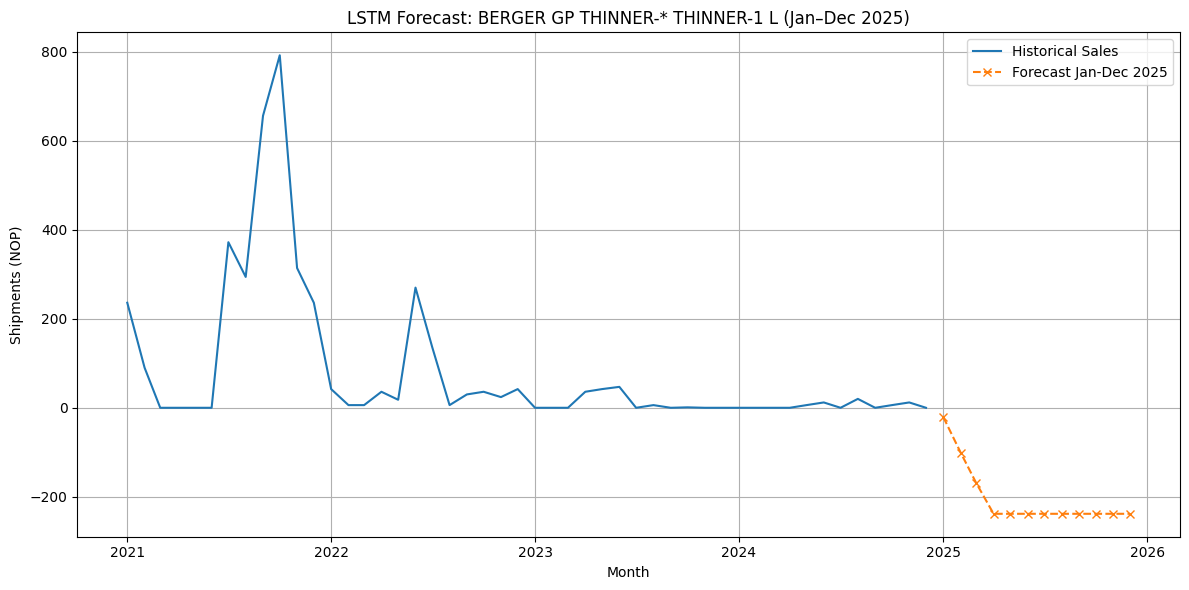

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from pandas.tseries.offsets import MonthBegin
import matplotlib.pyplot as plt

# ---- Data Loading and Preparation ----
df = pd.read_csv('Sales Data.csv')  # Update with your file name if needed
sku = 'F00T650900001000'
product = 'BERGER GP THINNER-* THINNER-1 L'

df_sku = df[(df['Item.[SKU]'] == sku) & (df['SKU Description'].str.upper() == product)].copy()
df_sku['year'] = df_sku['Time.[Planning Year]'].str.extract(r'(\d{4})').astype(int)
df_sku['month'] = df_sku['Time.[Planning Month]'].str[:3]
df_sku['date'] = pd.to_datetime(df_sku['month'] + ' ' + df_sku['year'].astype(str), format='%b %Y')

# ---- Aggregate monthly sales ----
monthly = df_sku.groupby('date')['Original Shipments in NOP'].sum().asfreq('MS').fillna(0)
df_feat = pd.DataFrame(monthly)
df_feat.columns = ['sales']

# ---- Feature Engineering ----
df_feat['month'] = df_feat.index.month
df_feat['year'] = df_feat.index.year
df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)
features = df_feat[['sales', 'month_sin', 'month_cos', 'year']].values

# ---- Scale features ----
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# ---- Data Sequencing for LSTM ----
def create_sequences(data, look_back=3):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 3
X, y = create_sequences(features_scaled, look_back)
split = int(0.85 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---- Define and train LSTM model ----
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(1)
])
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0, validation_split=0.1, callbacks=[early_stop])

# ---- Evaluate model ----
y_pred_scaled = model.predict(X_test)
last_features = X_test[:, -1, 1:]
y_pred_pad = np.hstack([y_pred_scaled, last_features])
y_test_pad = np.hstack([y_test.reshape(-1, 1), last_features])
y_pred = scaler.inverse_transform(y_pred_pad)[:, 0]
y_true = scaler.inverse_transform(y_test_pad)[:, 0]

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

print("Evaluation Metrics (Test Set):")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAPE: {mape:.2f}%")

# ---- Recursive forecasting for Jan–Dec 2025 ----
pred_months = 12
last_sequence = features_scaled[-look_back:]
future_preds_scaled = []
future_year = int(df_feat.index[-1].year)  # Start year for future prediction

for i in range(pred_months):
    pred_input = last_sequence.reshape((1, look_back, features.shape[1]))
    pred_scaled = model.predict(pred_input, verbose=0)[0, 0]
    # Generate correct month/year
    future_month = (df_feat.index[-1].month + i + 1 - 1) % 12 + 1
    if i > 0 and future_month == 1:  # Increment year at January
        future_year += 1
    month_sin = np.sin(2 * np.pi * future_month / 12)
    month_cos = np.cos(2 * np.pi * future_month / 12)
    new_features = np.array([[pred_scaled, month_sin, month_cos, future_year]])
    future_preds_scaled.append(pred_scaled)
    last_sequence = np.vstack([last_sequence[1:], new_features])

# Prepare for inverse scaling
future_feature_matrix = []
future_year = int(df_feat.index[-1].year)
for i, pred_scaled in enumerate(future_preds_scaled):
    month_number = (df_feat.index[-1].month + i + 1 - 1) % 12 + 1
    if i > 0 and month_number == 1:
        future_year += 1
    month_sin = np.sin(2 * np.pi * month_number / 12)
    month_cos = np.cos(2 * np.pi * month_number / 12)
    future_feature_matrix.append([pred_scaled, month_sin, month_cos, future_year])
future_feature_matrix = np.array(future_feature_matrix)
future_preds = scaler.inverse_transform(future_feature_matrix)[:, 0]

# Dates for forecast
start_pred_date = df_feat.index[-1] + MonthBegin(1)
pred_dates = pd.date_range(start=start_pred_date, periods=pred_months, freq='MS')
forecast_df = pd.DataFrame({'Month': pred_dates, 'Forecasted_Sales': future_preds})
forecast_df.set_index('Month', inplace=True)
print(forecast_df)

# ---- Visualization ----
plt.figure(figsize=(12, 6))
plt.plot(df_feat.index, df_feat['sales'], label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecasted_Sales'], marker='x', linestyle='--', label='Forecast Jan-Dec 2025')
plt.title('LSTM Forecast: BERGER GP THINNER-* THINNER-1 L (Jan–Dec 2025)')
plt.xlabel('Month')
plt.ylabel('Shipments (NOP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Experiment 2: Forecast monthly sales (Original Shipments in NOP) for Berger GP Thinner PET- THINNER-1 L (SKU: F0003E0900001000)**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 270ms/step - loss: 0.1302 - val_loss: 0.0541
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0725 - val_loss: 0.0479
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0941 - val_loss: 0.0637
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0659 - val_loss: 0.0790
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0941 - val_loss: 0.0827
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0579 - val_loss: 0.0700
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0468 - val_loss: 0.0635
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0652 - val_loss: 0.0678
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0784 - val_loss: 0.0701
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0658 - val_loss: 0.0751
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0741 - val_loss: 0.0764
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0666 - val_l

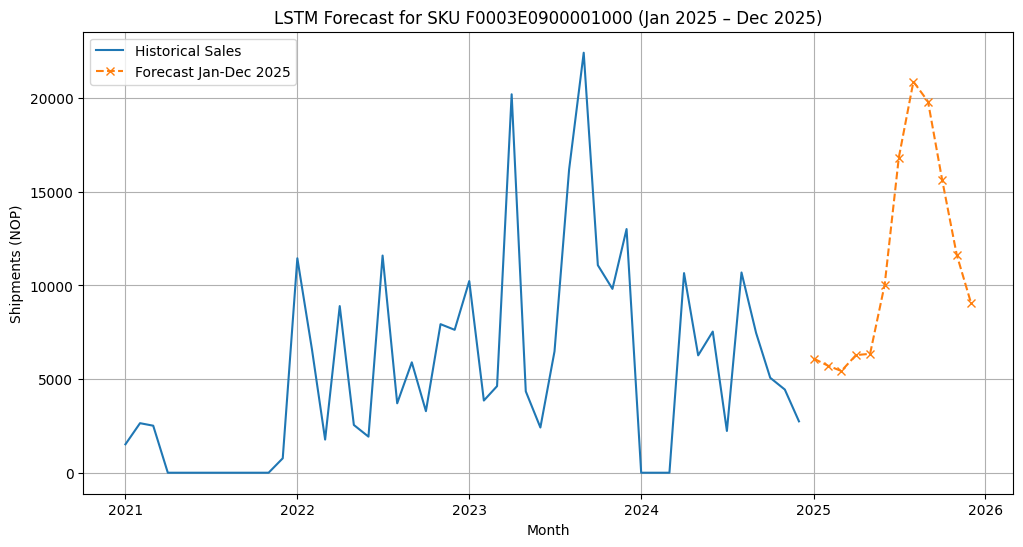

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pandas.tseries.offsets import MonthBegin
import matplotlib.pyplot as plt

# 1. Load and filter the data for the target SKU and product
df = pd.read_csv('Sales Data.csv')
sku = 'F0003E0900001000'
product = 'Berger GP Thinner PET-* THINNER-1 L'
df_sku = df[(df['Item.[SKU]'] == sku) & (df['SKU Description'] == product)].copy()

# 2. Prepare datetime fields
df_sku['year'] = df_sku['Time.[Planning Year]'].str.extract(r'(\d{4})').astype(int)
df_sku['month_str'] = df_sku['Time.[Planning Month]'].str[:3]
df_sku['date'] = pd.to_datetime(df_sku['month_str'] + ' ' + df_sku['year'].astype(str), format='%b %Y')

# 3. Aggregate monthly sales and fill missing months
monthly_sales = df_sku.groupby('date', as_index=False)['Original Shipments in NOP'].sum()
monthly_sales = monthly_sales.sort_values('date').set_index('date')
full_index = pd.date_range(monthly_sales.index.min(), monthly_sales.index.max(), freq='MS')
monthly_sales = monthly_sales.reindex(full_index)
monthly_sales['Original Shipments in NOP'] = monthly_sales['Original Shipments in NOP'].fillna(0)

# 4. Add seasonal features
monthly_sales['month'] = monthly_sales.index.month
monthly_sales['month_sin'] = np.sin(2 * np.pi * monthly_sales['month'] / 12)
monthly_sales['month_cos'] = np.cos(2 * np.pi * monthly_sales['month'] / 12)

# 5. Scale features
features = np.hstack([
    monthly_sales['Original Shipments in NOP'].values.reshape(-1, 1),
    monthly_sales['month_sin'].values.reshape(-1, 1),
    monthly_sales['month_cos'].values.reshape(-1, 1)
])
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# 6. Build input/output sequences for LSTM
def create_sequences(data, look_back=3):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 3
X, y = create_sequences(features_scaled, look_back)
split_at = int(0.85 * len(X))
X_train, X_test = X[:split_at], X[split_at:]
y_train, y_test = y[:split_at], y[split_at:]

# 7. Build and train the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=6, verbose=1, validation_split=0.1)

# 8. Evaluate on test set
y_pred_scaled = model.predict(X_test)
last_features = X_test[:, -1, 1:]
y_pred_pad = np.hstack([y_pred_scaled, last_features])
y_test_pad = np.hstack([y_test.reshape(-1,1), last_features])
y_pred = scaler.inverse_transform(y_pred_pad)[:, 0]
y_true = scaler.inverse_transform(y_test_pad)[:, 0]

# 9. Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100

print("Evaluation Metrics (Test Set):")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAPE: {mape:.2f}%")

# 10. Recursive forecast for Jan–Dec 2025
pred_months = 12
last_sequence = features_scaled[-look_back:]
future_preds_scaled = []
for i in range(pred_months):
    pred_input = last_sequence.reshape((1, look_back, features.shape[1]))
    pred_scaled = model.predict(pred_input, verbose=0)[0, 0]
    future_month_number = (monthly_sales.index[-1].month + i + 1 - 1) % 12 + 1
    month_sin = np.sin(2 * np.pi * future_month_number / 12)
    month_cos = np.cos(2 * np.pi * future_month_number / 12)
    new_features = np.array([[pred_scaled, month_sin, month_cos]])
    future_preds_scaled.append(pred_scaled)
    last_sequence = np.vstack([last_sequence[1:], new_features])

# 11. Inverse scale predictions
future_feature_matrix = []
for i, pred_scaled in enumerate(future_preds_scaled):
    month_number = (monthly_sales.index[-1].month + i + 1 - 1) % 12 + 1
    month_sin = np.sin(2 * np.pi * month_number / 12)
    month_cos = np.cos(2 * np.pi * month_number / 12)
    future_feature_matrix.append([pred_scaled, month_sin, month_cos])
future_feature_matrix = np.array(future_feature_matrix)
future_preds = scaler.inverse_transform(future_feature_matrix)[:, 0]

# 12. Output forecast as table
start_pred_date = monthly_sales.index[-1] + MonthBegin(1)
pred_dates = pd.date_range(start=start_pred_date, periods=pred_months, freq='MS')
forecast_df = pd.DataFrame({'Month': pred_dates, 'Forecasted_Sales': future_preds})
forecast_df.set_index('Month', inplace=True)
print(forecast_df)

# 13. Plot results
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['Original Shipments in NOP'], label='Historical Sales')
plt.plot(forecast_df.index, forecast_df['Forecasted_Sales'], marker='x', linestyle='--', label='Forecast Jan-Dec 2025')
plt.title('LSTM Forecast for SKU F0003E0900001000 (Jan 2025 – Dec 2025)')
plt.xlabel('Month')
plt.ylabel('Shipments (NOP)')
plt.legend()
plt.grid(True)
plt.show()
